# report stats, monitor change

record properties of ``treedb.sqlite3``
loaded from [Glottolog](https://glottolog.org)
[master repo](https://github.com/glottolog/glottolog) commit
and monitor changes by diffing this

<div style="text-align: right">
  <a href="https://nbviewer.jupyter.org/github/glottolog/treedb/blob/master/Stats.ipynb">
      latest version from GitHub in nbviewer
  </a>
</div>

### contents
1. [clone/checkout](#clone/checkout)
2. [load](#load)
3. [treedb.sqlite3](#treedb.sqlite3)
4. [\_\_dataset\_\_](#__dataset__)
5. [\_\_producer\_\_](#__producer__)
6. [treedb.raw](#treedb.raw)
7. [languoid](#languoid)
8. [macroarea](#macroarea)
9. [country](#country)
10. [endangerment](#endangerment)
11. [link](#link)
12. [denormalized](#denormalized)

In [1]:
%matplotlib inline

import collections

import pandas as pd
import sqlalchemy as sa
import matplotlib as mpl
import matplotlib.pyplot as plt

import treedb
import treedb.raw

treedb.configure_logging(log_sql=False)

treedb.__version__

'1.0.1.dev0'

## clone/checkout

In [2]:
%%time

TARGET = '../glottolog/'

TAG = 'v4.2.1'

treedb.checkout_or_clone(TAG, target=TARGET)

Wall time: 2.75 s


(None,
 CompletedProcess(args=['git', 'checkout', '-B', 'treedb', 'v4.2.1'], returncode=0))

## load

In [3]:
treedb.set_root(TARGET)

<treedb.proxies.PathProxy path='../glottolog/languoids/tree' inode=56013520365887128>

In [4]:
next(treedb.iterfiles())

(('abin1243',), <DirEntry 'md.ini'>, <treedb.files.ConfigParser at 0x50fe0d0>)

In [5]:
next(treedb.iterlanguoids())

(('abin1243',),
 {'id': 'abin1243',
  'parent_id': None,
  'level': 'language',
  'name': 'Abinomn',
  'hid': 'bsa',
  'iso639_3': 'bsa',
  'latitude': -2.92281,
  'longitude': 138.891,
  'macroareas': ['Papunesia'],
  'countries': [{'name': 'Indonesia', 'id': 'ID'}],
  'links': [{'url': 'http://endangeredlanguages.com/lang/1763',
    'title': 'Abinomn',
    'scheme': 'http'},
   {'url': 'https://www.wikidata.org/entity/Q56648',
    'title': None,
    'scheme': 'https'},
   {'url': 'https://en.wikipedia.org/wiki/Abinomn_language',
    'title': None,
    'scheme': 'https'}],
  'sources': {'glottolog': [{'bibfile': 'hh',
     'bibkey': 'e:Lagerberg:Moegip',
     'pages': None,
     'trigger': None},
    {'bibfile': 'hh',
     'bibkey': 'h:SilzerClouse:Index',
     'pages': None,
     'trigger': None},
    {'bibfile': 'hh',
     'bibkey': 'h:SilzerHeikkinen:Irian',
     'pages': None,
     'trigger': None},
    {'bibfile': 'hh',
     'bibkey': 'hv:Foley:Northwest-New-Guinea',
     'pages'

In [6]:
treedb.set_engine('treedb.sqlite3')

<treedb.proxies.SQLiteEngineProxy filename='treedb.sqlite3' size=0>

In [7]:
%%time

engine = treedb.load(rebuild=False, exclude_raw=False)
engine

0:02:13.468634
Wall time: 2min 13s


<treedb.proxies.SQLiteEngineProxy filename='treedb.sqlite3' size=87179264>

In [8]:
engine.file_mtime()

datetime.datetime(2020, 4, 19, 22, 13, 0, 707168)

In [9]:
engine.file_size(as_megabytes=True)

83.140625

In [10]:
%time engine.file_sha256()

Wall time: 631 ms


'6f80b4aab26b8eede29b3c052db0bd98ec130e265f98d40a0a576b5a6a3f6dde'

In [11]:
%time treedb.raw.checksum()

Wall time: 529 ms


'strong:sha256:03ae265f46c79a5fd9ae44ada3ed50840dbdb897384b7ac57456ba12b6206a71'

In [12]:
%time treedb.raw.checksum(weak=True)

Wall time: 9.56 s


'weak:sha256:9cf661e51d8cd6d8ef1f5e93dbbf4612a8a7e06712c56747d7a280b2d83f503b'

In [13]:
%time treedb.check()

valid_glottocodeCheck: OK
valid_iso639_3Check: OK
valid_hidCheck: OK
clean_nameCheck: OK
family_parentCheck: OK
language_parentCheck: OK
dialect_parentCheck: OK
family_childrenCheck: OK
family_languagesCheck: OK
bookkeeping_no_childrenCheck: OK
no_empty_filesCheck: OK
Wall time: 2.88 s


True

In [14]:
%time treedb.checksum()

Wall time: 11.3 s


'path_json:id:sha256:1e1254feb7ebaefd0a3c45de3eca194349203403468c0561b65d283777b18ff5'

In [15]:
%time treedb.checksum(source='raw')

Wall time: 13.5 s


'path_json:id:sha256:1e1254feb7ebaefd0a3c45de3eca194349203403468c0561b65d283777b18ff5'

## treedb.sqlite3

In [16]:
from treedb import count, select, text

treedb.configure_logging(level='INFO', log_sql=True)
    
select([sa.func.sqlite_version()]).scalar()

[INFO@treedb.logging_] treedb version: 1.0.1.dev0
SELECT sqlite_version() AS sqlite_version_1
()


'3.31.1'

In [17]:
application_id = text('PRAGMA application_id').scalar()

assert application_id == 1122 == 0x462
assert application_id == sum(ord(c) for c in treedb.Dataset.__tablename__)
assert treedb.Dataset.__tablename__ == '__dataset__'

application_id

PRAGMA application_id
()


1122

In [18]:
from treedb import pd_read_sql as read_sql

read_sql(treedb.select_tables_nrows(), index_col='table_name')

SELECT sqlite_master.name 
FROM sqlite_master 
WHERE sqlite_master.type = ? AND sqlite_master.name NOT LIKE ? ORDER BY sqlite_master.name
('table', 'sqlite_%')
SELECT ? AS table_name, (SELECT count(*) AS n 
FROM __dataset__) AS n_rows UNION ALL SELECT ? AS table_name, (SELECT count(*) AS n 
FROM __producer__) AS n_rows UNION ALL SELECT ? AS table_name, (SELECT count(*) AS n 
FROM _file) AS n_rows UNION ALL SELECT ? AS table_name, (SELECT count(*) AS n 
FROM _option) AS n_rows UNION ALL SELECT ? AS table_name, (SELECT count(*) AS n 
FROM _value) AS n_rows UNION ALL SELECT ? AS table_name, (SELECT count(*) AS n 
FROM altname) AS n_rows UNION ALL SELECT ? AS table_name, (SELECT count(*) AS n 
FROM bibfile) AS n_rows UNION ALL SELECT ? AS table_name, (SELECT count(*) AS n 
FROM bibitem) AS n_rows UNION ALL SELECT ? AS table_name, (SELECT count(*) AS n 
FROM classificationcomment) AS n_rows UNION ALL SELECT ? AS table_name, (SELECT count(*) AS n 
FROM classificationref) AS n_rows UNION ALL 

,n_rows
table_name,
__dataset__,1
__producer__,1
_file,25228
_option,53
_value,600096
altname,149531
bibfile,37
bibitem,143220
classificationcomment,11791


In [19]:
treedb.print_rows(treedb.sqlite_master.select_views(), format_='{name}')

SELECT sqlite_master.name 
FROM sqlite_master 
WHERE sqlite_master.type = ? AND sqlite_master.name NOT LIKE ? ORDER BY sqlite_master.name
('view', 'sqlite_%')


example
path_json
stats


In [20]:
from treedb import print_table_sql as print_sql

print_sql('sqlite_master')

SELECT sqlite_master.sql 
FROM sqlite_master 
WHERE sqlite_master.type = ? AND sqlite_master.name = ?
('table', 'sqlite_master')


None


SELECT count(*) AS n_rows 
FROM sqlite_master
()


63


## \_\_dataset\_\_

In [21]:
from treedb import Dataset

print_sql(Dataset)

SELECT sqlite_master.sql 
FROM sqlite_master 
WHERE sqlite_master.type = ? AND sqlite_master.name = ?
('table', '__dataset__')


CREATE TABLE __dataset__ (
	id INTEGER NOT NULL CHECK (id = 1), 
	title TEXT NOT NULL CHECK (title != ''), 
	git_commit VARCHAR(40) NOT NULL CHECK (length(git_commit) = 40), 
	git_describe TEXT NOT NULL CHECK (git_describe != ''), 
	clean BOOLEAN NOT NULL, 
	exclude_raw BOOLEAN NOT NULL, 
	PRIMARY KEY (id), 
	UNIQUE (git_commit), 
	UNIQUE (git_describe), 
	CHECK (clean IN (0, 1)), 
	CHECK (exclude_raw IN (0, 1))
)


SELECT count(*) AS n_rows 
FROM __dataset__
()


1


In [22]:
dataset, = select([Dataset]).execute()

pd.DataFrame.from_dict(dataset, orient='index', columns=['__dataset__'])

SELECT __dataset__.id, __dataset__.title, __dataset__.git_commit, __dataset__.git_describe, __dataset__.clean, __dataset__.exclude_raw 
FROM __dataset__
()


,__dataset__
id,1
title,Glottolog treedb
git_commit,e49bc948c1195a8a5c5a85e1ea9293ea7412602e
git_describe,v4.2.1
clean,True
exclude_raw,False


## \_\_producer\_\_

In [23]:
from treedb import Producer

print_sql(Producer)

SELECT sqlite_master.sql 
FROM sqlite_master 
WHERE sqlite_master.type = ? AND sqlite_master.name = ?
('table', '__producer__')


CREATE TABLE __producer__ (
	id INTEGER NOT NULL CHECK (id = 1), 
	name TEXT NOT NULL CHECK (name != ''), 
	version TEXT NOT NULL CHECK (version != ''), 
	PRIMARY KEY (id), 
	UNIQUE (name)
)


SELECT count(*) AS n_rows 
FROM __producer__
()


1


In [24]:
producer, = select([Producer]).execute()

pd.DataFrame.from_dict(producer, orient='index', columns=['__producer__'])

SELECT __producer__.id, __producer__.name, __producer__.version 
FROM __producer__
()


,__producer__
id,1
name,treedb
version,1.0.1.dev0


## `treedb.raw`

In [25]:
from treedb.raw import File, Option, Value

for model in (File, Option, Value):
    print_sql(model)

SELECT sqlite_master.sql 
FROM sqlite_master 
WHERE sqlite_master.type = ? AND sqlite_master.name = ?
('table', '_file')


CREATE TABLE _file (
	id INTEGER NOT NULL, 
	glottocode VARCHAR(8) NOT NULL CHECK (length(glottocode) = 8), 
	path TEXT NOT NULL CHECK (length(path) >= 8 AND (length(path) + 1) % 9 = 0), 
	size INTEGER NOT NULL CHECK (size > 0), 
	sha256 VARCHAR(64) NOT NULL CHECK (length(sha256) = 64), 
	PRIMARY KEY (id), 
	CHECK (substr(path, -length(glottocode)) = glottocode), 
	UNIQUE (glottocode), 
	UNIQUE (path), 
	UNIQUE (sha256)
)


SELECT count(*) AS n_rows 
FROM _file
()


25228


SELECT sqlite_master.sql 
FROM sqlite_master 
WHERE sqlite_master.type = ? AND sqlite_master.name = ?
('table', '_option')


CREATE TABLE _option (
	id INTEGER NOT NULL, 
	section TEXT NOT NULL CHECK (section != ''), 
	option TEXT NOT NULL CHECK (option != ''), 
	is_lines BOOLEAN, 
	PRIMARY KEY (id), 
	UNIQUE (section, option), 
	CHECK (is_lines IN (0, 1))
)


SELECT count(*) AS n_rows 
FROM _option
()


53


SELECT sqlite_master.sql 
FROM sqlite_master 
WHERE sqlite_master.type = ? AND sqlite_master.name = ?
('table', '_value')


CREATE TABLE _value (
	file_id INTEGER NOT NULL, 
	option_id INTEGER NOT NULL, 
	line INTEGER NOT NULL CHECK (line > 0), 
	value TEXT NOT NULL CHECK (value != ''), 
	PRIMARY KEY (file_id, option_id, line), 
	UNIQUE (file_id, line), 
	FOREIGN KEY(file_id) REFERENCES _file (id), 
	FOREIGN KEY(option_id) REFERENCES _option (id)
) WITHOUT ROWID




SELECT count(*) AS n_rows 
FROM _value
()


600096


In [26]:
read_sql(select([File]).limit(5), index_col='id')

SELECT _file.id, _file.glottocode, _file.path, _file.size, _file.sha256 
FROM _file
 LIMIT ? OFFSET ?
(5, 0)


,glottocode,path,size,sha256
id,,,,
1,abin1243,abin1243,1229,b7c19c6bc411908419022568fa021e39d64b1e9ab2e57c...
2,abis1238,abis1238,1708,b0d8c9aca4d8dcca721e8dac7ff33c4f51f116ad300f35...
3,abkh1242,abkh1242,306,5dd28ae1265a0967b1a236d06c7fd6e7ac3b9e32d866dd...
4,abkh1243,abkh1242/abkh1243,257,a5900355c69af22d94eaa0a147b95fc291270634bc033c...
5,abaz1241,abkh1242/abkh1243/abaz1241,2450,1f9258cffd448ed9eb5b243d7252bb183aa89558904f8e...


In [27]:
read_sql(select([Option]).limit(5), index_col='id')

SELECT _option.id, _option.section, _option.option, _option.is_lines 
FROM _option
 LIMIT ? OFFSET ?
(5, 0)


,section,option,is_lines
id,,,
1,core,name,False
2,core,hid,False
3,core,level,False
4,core,iso639-3,False
5,core,latitude,False


In [28]:
read_sql(select([Value]).limit(5), index_col=['file_id', 'option_id'])

SELECT _value.file_id, _value.option_id, _value.line, _value.value 
FROM _value
 LIMIT ? OFFSET ?
(5, 0)


line     value
file_id option_id                
1       1             1   Abinomn
        2             2       bsa
        3             3  language
        4             4       bsa
        5             5  -2.92281

In [29]:
select_file_values = select([Option.section, Option.option, Value.line, Value.value])\
                     .select_from(sa.join(File, Value).join(Option))\
                     .where(File.glottocode == sa.bindparam('glottocode'))

read_sql(select_file_values, params={'glottocode': 'abin1243'},
         index_col=['section', 'option', 'line'])

SELECT _option.section, _option.option, _value.line, _value.value 
FROM _file JOIN _value ON _file.id = _value.file_id JOIN _option ON _option.id = _value.option_id 
WHERE _file.glottocode = ?
('abin1243',)


value
section        option              line                                                   
core           name                1                                               Abinomn
               hid                 2                                                   bsa
               level               3                                              language
               iso639-3            4                                                   bsa
               latitude            5                                              -2.92281
               longitude           6                                               138.891
               macroareas          7                                             Papunesia
               countries           8                                        Indonesia (ID)
               links               9     [Abinomn](http://endangeredlanguages.com/lang/...
                                   10               https://www.wikidata.org/entity/Q56648
                                   11       https://en.wikipedia.org/wiki/Abinomn_language
sources        glottolog           12                            **hh:e:Lagerberg:Moegip**
                                   13                          **hh:h:SilzerClouse:Index**
                                   14                       **hh:h:SilzerHeikkinen:Irian**
                                   15                 **hh:hv:Foley:Northwest-New-Guinea**
                                   16               **hh:hvtyp:DonohueMusgrave:Melanesia**
                                   17                               **hh:w:Fiwei:Abinomn**
altnames       multitree           18                                               "Baso"
                                   19                                              Abinomn
                                   20                                             Avinomen
                                   21                                                 Foja
                                   22                                                 Foya
               lexvo               23                                         Abinomn [en]
                                   24                                Abinomn language [en]
                                   25                                       Abinomneg [br]
                                   26                                  Lingua abinomn [gl]
                                   27                                Llingua Abinomn [ast]
               hhbib_lgcode        28                                                 Baso
               elcat               29                                               "Baso"
                                   30                                              Abinomn
                                   31                                             Avinomen
                                   32                                                 Foja
                                   33                                                 Foya
triggers       lgcode              34                                         macrohistory
                                   35                                               moegip
identifier     multitree           36                                                  bsa
               endangeredlanguages 37                                                 1763
classification familyrefs          38                          **hh:h:SilzerClouse:Index**
                                   39               **hh:hvtyp:DonohueMusgrave:Melanesia**
endangerment   status              40                                             shifting
               source              41                                                ElCat
               date                42                                  2017-08-19T08:16:16
               comment             43    Abinomn (1763-bsa) = Endangered (20 perc

SELECT (length(_file.path) + ?) / ? AS path_depth, languoid.level, count(*) AS n_files 
FROM _file JOIN languoid ON _file.glottocode = languoid.id GROUP BY (length(_file.path) + ?) / ?, languoid.level ORDER BY path_depth, languoid.level
(1, 9, 1, 9)
[INFO@numexpr.utils] NumExpr defaulting to 4 threads.


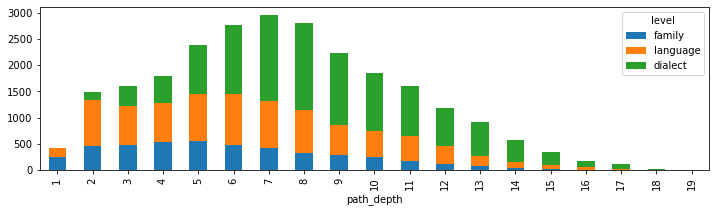

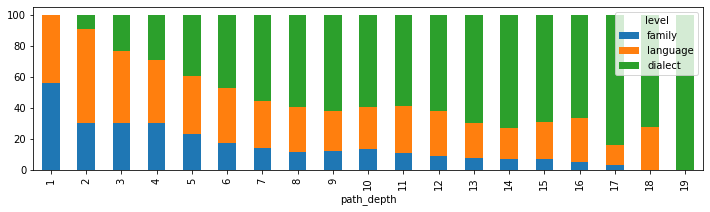

In [30]:
path_depth = File.path_depth()

select_path_depths = select([path_depth,
                             treedb.Languoid.level, count().label('n_files')])\
                     .select_from(sa.join(File, treedb.Languoid,
                                          File.glottocode == treedb.Languoid.id))\
                     .group_by(path_depth, treedb.Languoid.level)\
                     .order_by('path_depth', 'level')

_ = read_sql(select_path_depths, index_col=['path_depth', 'level'])\
    .unstack(fill_value=0).droplevel(0, axis='columns')[list(treedb.LEVEL)]

_.plot.bar(stacked=True, figsize=(12, 3))

(100 * _.div(_.sum(axis='columns'), axis='rows')).plot.bar(stacked=True, figsize=(12, 3));

SELECT _file.size AS file_size, count(*) AS n_files 
FROM _file GROUP BY _file.size ORDER BY file_size
()


,file_size
min,65.0
max,46101.0


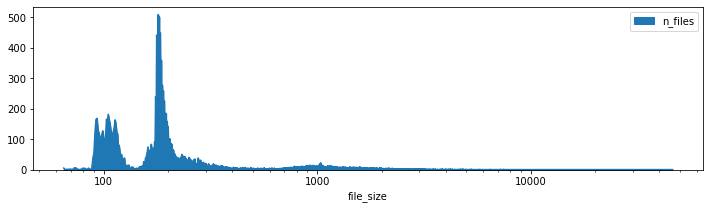

In [31]:
file_size = File.size.label('file_size')

select_file_sizes = select([file_size, count().label('n_files')])\
                    .group_by(file_size)\
                    .order_by('file_size')

_ = read_sql(select_file_sizes, index_col='file_size')

_.plot.area(figsize=(12, 3), logx=True).xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
_.index.to_series().describe().to_frame().loc[['min', 'max']]

SELECT n_values, count(*) AS n_files 
FROM (SELECT _file.glottocode AS glottocode, count(DISTINCT _value.option_id) AS n_values 
FROM _file JOIN _value ON _file.id = _value.file_id GROUP BY _file.glottocode) GROUP BY n_values ORDER BY n_values
()


,n_values
min,2.0
max,36.0


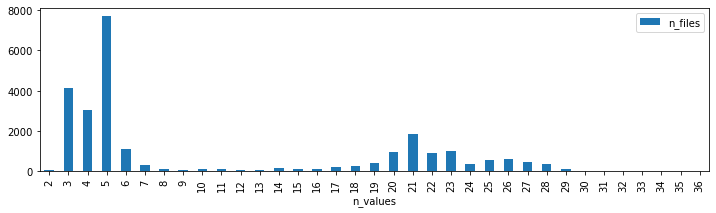

In [32]:
file_nvalues = select([File.glottocode,
                       count(Value.option_id.distinct()).label('n_values')])\
               .select_from(sa.join(File, Value))\
               .group_by(File.glottocode).c.n_values

select_nvalues = select([file_nvalues, count().label('n_files')])\
                 .group_by(file_nvalues)\
                 .order_by(file_nvalues)

_ = read_sql(select_nvalues, index_col=['n_values'])

_.plot.bar(figsize=(12, 3))
_.index.to_series().describe().to_frame().loc[['min', 'max']]

SELECT length(_value.value) AS value_length, count(*) AS n_values 
FROM _value GROUP BY length(_value.value) ORDER BY value_length
()


,value_length
min,1.0
max,6215.0


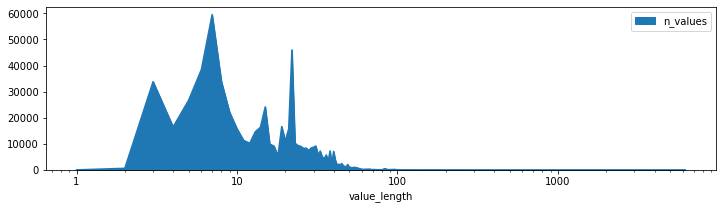

In [33]:
value_length = sa.func.length(Value.value).label('value_length')

select_value_length = select([value_length, count().label('n_values')])\
                      .group_by(value_length)\
                      .order_by('value_length')

_ = read_sql(select_value_length, index_col='value_length')

_.plot.area(figsize=(12, 3), logx=True).xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
_.index.to_series().describe().to_frame().loc[['min', 'max']]

In [34]:
%time treedb.raw.print_stats()

[INFO@treedb.raw.values] fetch statistics
SELECT _option.section, _option.option, count(*) AS n 
FROM _option JOIN _value ON _option.id = _value.option_id GROUP BY _option.section, _option.option ORDER BY _option.section, n DESC
()


altnames               multitree              54,614
altnames               hhbib_lgcode           29,050
altnames               lexvo                  26,027
altnames               elcat                  23,424
altnames               aiatsis                6,542
altnames               wals                   2,441
altnames               wals other             2,097
altnames               moseley & asher (1994) 2,089
altnames               ruhlen (1987)          2,007
altnames               glottolog              1,237
altnames               ethnologue             3
classification         subrefs                15,344
classification         sub                    11,584
classification         familyrefs             699
classification         family                 207
core                   links                  28,949
core                   name                   25,228
core                   level                  25,228
core                   macroareas             20,700
core      

## languoid

In [35]:
from treedb import LEVEL, Languoid

FAMILY, LANGUAGE, DIALECT = LEVEL

print_sql(Languoid)

SELECT sqlite_master.sql 
FROM sqlite_master 
WHERE sqlite_master.type = ? AND sqlite_master.name = ?
('table', 'languoid')


CREATE TABLE languoid (
	id VARCHAR(8) NOT NULL CHECK (length(id) = 8), 
	name VARCHAR NOT NULL CHECK (name != ''), 
	level VARCHAR(8) NOT NULL, 
	parent_id VARCHAR(8), 
	hid TEXT CHECK (length(hid) >= 3), 
	iso639_3 VARCHAR(3) CHECK (length(iso639_3) = 3), 
	latitude FLOAT CHECK (latitude BETWEEN -90 AND 90), 
	longitude FLOAT CHECK (longitude BETWEEN -180 AND 180), 
	PRIMARY KEY (id), 
	CHECK ((latitude IS NULL) = (longitude IS NULL)), 
	UNIQUE (name), 
	CHECK (level IN ('family', 'language', 'dialect')), 
	FOREIGN KEY(parent_id) REFERENCES languoid (id) DEFERRABLE INITIALLY DEFERRED, 
	UNIQUE (hid), 
	UNIQUE (iso639_3)
)


SELECT count(*) AS n_rows 
FROM languoid
()


25228


In [36]:
%time treedb.print_languoid_stats()

WITH RECURSIVE tree(child_id, parent_id, terminal) AS 
(SELECT child.id AS child_id, parent.id AS parent_id, parent.parent_id IS NULL AS terminal 
FROM languoid AS child JOIN languoid AS parent ON child.parent_id = parent.id UNION ALL SELECT tree.child_id AS child_id, parent.parent_id AS parent_id, grandparent.parent_id IS NULL AS terminal 
FROM tree JOIN languoid AS parent ON parent.id = tree.parent_id AND parent.parent_id IS NOT NULL LEFT OUTER JOIN languoid AS grandparent ON grandparent.id = parent.parent_id)
 SELECT ? AS kind, count(*) AS n 
FROM languoid UNION ALL SELECT ? AS kind, count(*) AS n 
FROM languoid 
WHERE languoid.level = ? AND languoid.parent_id IS NULL UNION ALL SELECT ? AS kind, count(*) AS n 
FROM languoid 
WHERE languoid.level = ? AND languoid.parent_id IS NULL UNION ALL SELECT ? AS kind, count(*) AS n 
FROM languoid 
WHERE languoid.parent_id IS NULL UNION ALL SELECT ? AS kind, count(*) AS n 
FROM languoid 
WHERE languoid.level = ? UNION ALL SELECT ? AS kind, coun

25,228 languoids
   242 families
   187 isolates
   429 roots
 8,515 languages
 4,234 subfamilies
12,237 dialects
 7,604 Spoken L1 Languages
   196 Sign Language
   123 Unclassifiable
    81 Pidgin
    66 Unattested
    28 Artificial Language
    14 Mixed Language
    10 Speech Register
 8,122 All
   393 Bookkeeping
Wall time: 9.8 s


In [37]:
read_sql(select([Languoid]).limit(5), index_col='id')

SELECT languoid.id, languoid.name, languoid.level, languoid.parent_id, languoid.hid, languoid.iso639_3, languoid.latitude, languoid.longitude 
FROM languoid
 LIMIT ? OFFSET ?
(5, 0)


,name,level,parent_id,hid,iso639_3,latitude,longitude
id,,,,,,,
3adt1234,3Ad-Tekles,dialect,nort3292,None,None,NaN,NaN
aala1237,Aalawa,dialect,ramo1244,None,None,NaN,NaN
aant1238,Aantantara,dialect,nort2920,None,None,NaN,NaN
aari1238,Aari-Gayil,family,ahkk1235,aiz,aiz,NaN,NaN
aari1239,Aari,language,aari1238,aiw,aiw,5.95034,36.5721


In [38]:
read_sql(select([Languoid]).order_by('id').limit(5), index_col='id')

SELECT languoid.id, languoid.name, languoid.level, languoid.parent_id, languoid.hid, languoid.iso639_3, languoid.latitude, languoid.longitude 
FROM languoid ORDER BY languoid.id
 LIMIT ? OFFSET ?
(5, 0)


,name,level,parent_id,hid,iso639_3,latitude,longitude
id,,,,,,,
3adt1234,3Ad-Tekles,dialect,nort3292,None,None,NaN,NaN
aala1237,Aalawa,dialect,ramo1244,None,None,NaN,NaN
aant1238,Aantantara,dialect,nort2920,None,None,NaN,NaN
aari1238,Aari-Gayil,family,ahkk1235,aiz,aiz,NaN,NaN
aari1239,Aari,language,aari1238,aiw,aiw,5.95034,36.5721


In [39]:
read_sql(select([Languoid]).order_by('name').limit(5), index_col='id')

SELECT languoid.id, languoid.name, languoid.level, languoid.parent_id, languoid.hid, languoid.iso639_3, languoid.latitude, languoid.longitude 
FROM languoid ORDER BY languoid.name
 LIMIT ? OFFSET ?
(5, 0)


,name,level,parent_id,hid,iso639_3,latitude,longitude
id,,,,,,,
gang1269,!Gã!nge,dialect,sero1239,None,None,NaN,NaN
kwii1241,!Kwi,family,tuuu1241,None,None,NaN,NaN
oung1238,!O!ung,language,book1242,oun,oun,-15.3,14.35
abda1238,'Abd Al-Kuri,dialect,soqo1240,None,None,NaN,NaN
aden1242,'Aden,dialect,jude1267,None,None,NaN,NaN


In [40]:
Child, Parent = (sa.orm.aliased(Languoid, name=n) for n in ('child', 'parent'))

select_parent_levels = select([Child.level.label('child_level'),
                               Parent.level.label('parent_level'),
                               count().label('n_languoids')])\
                       .select_from(sa.outerjoin(Child, Parent,
                                                 Child.parent_id == Parent.id))\
                       .group_by(Child.level, Parent.level)\
                       .order_by('child_level', 'parent_level')

read_sql(select_parent_levels, index_col=['child_level', 'parent_level'])\
    .unstack(fill_value=0).assign(all=lambda x: x.sum(axis='columns'))\
    .pipe(lambda x: x.append(x.sum().rename('all')))

SELECT child.level AS child_level, parent.level AS parent_level, count(*) AS n_languoids 
FROM languoid AS child LEFT OUTER JOIN languoid AS parent ON child.parent_id = parent.id GROUP BY child.level, parent.level ORDER BY child_level, parent_level
()


n_languoids                            all
parent_level         NaN dialect family language       
child_level                                            
dialect                0    1781      0    10456  12237
family               242       0   4234        0   4476
language             187       0   8328        0   8515
all                  429    1781  12562    10456  25228

In [41]:
select_nisos = select([Languoid.level.label('level'),
                       count().label('n_languoids'),
                       count(Languoid.iso639_3).label('n_isos')])\
               .group_by(Languoid.level)\
               .order_by('level')

read_sql(select_nisos, index_col=['level'])\
    .assign(ratio=lambda x: 100 * x['n_isos'] / x['n_languoids'])

SELECT languoid.level AS level, count(*) AS n_languoids, count(languoid.iso639_3) AS n_isos 
FROM languoid GROUP BY languoid.level ORDER BY level
()


,n_languoids,n_isos,ratio
level,,,
dialect,12237,177,1.446433
family,4476,45,1.005362
language,8515,7810,91.720493


In [42]:
select_nlocations = select([Languoid.level.label('level'),
                            count().label('n_languoids'),
                            count(Languoid.latitude).label('n_locations')])\
                    .group_by(Languoid.level)\
                    .order_by('level')

read_sql(select_nlocations, index_col=['level'])\
    .assign(ratio=lambda x: 100 * x['n_locations'] / x['n_languoids'])

SELECT languoid.level AS level, count(*) AS n_languoids, count(languoid.latitude) AS n_locations 
FROM languoid GROUP BY languoid.level ORDER BY level
()


,n_languoids,n_locations,ratio
level,,,
dialect,12237,260,2.124704
family,4476,17,0.379803
language,8515,8125,95.419847


SELECT languoid.latitude, languoid.longitude 
FROM languoid 
WHERE languoid.level = ?
('language',)


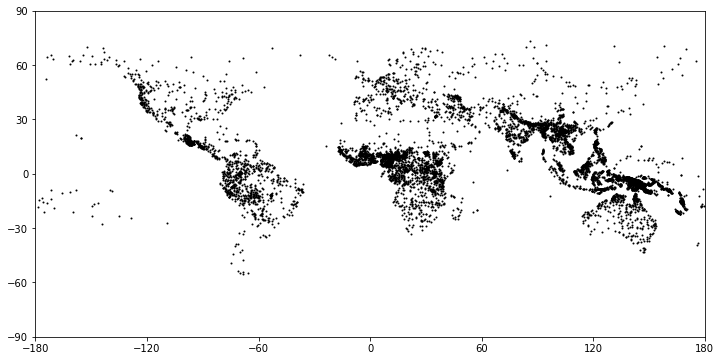

In [43]:
select_latlon = select([Languoid.latitude, Languoid.longitude])\
                .where(Languoid.level == LANGUAGE)

latitudes, longitudes = zip(*select_latlon.execute())
    
plt.figure(figsize=(12, 6))
plt.axis([-180, 180, -90, 90])
plt.xticks(range(-180, 181, 60))
plt.yticks(range(-90, 91, 30))
plt.scatter(longitudes, latitudes, 1, 'black');

WITH RECURSIVE tree(child_id, parent_id) AS 
(SELECT child.id AS child_id, parent.id AS parent_id 
FROM languoid AS child JOIN languoid AS parent ON child.parent_id = parent.id UNION ALL SELECT tree.child_id AS child_id, parent.parent_id AS parent_id 
FROM tree JOIN languoid AS parent ON parent.id = tree.parent_id AND parent.parent_id IS NOT NULL)
 SELECT family.id AS family_id, count(child.id) AS n_languages 
FROM languoid AS family LEFT OUTER JOIN (languoid AS child JOIN tree ON tree.child_id = child.id) ON tree.parent_id = family.id 
WHERE family.parent_id IS NULL AND family.level = ? AND child.level = ? GROUP BY family.id 
HAVING count(child.id) >= ? ORDER BY n_languages
('family', 'language', 100)


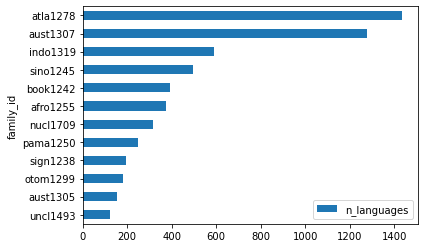

In [44]:
tree = treedb.Languoid.tree()

Family = sa.orm.aliased(treedb.Languoid, name='family')

child_tree = sa.join(Child, tree, tree.c.child_id == Child.id)
family_child = sa.outerjoin(Family, child_tree, tree.c.parent_id == Family.id)

n_languages = count(Child.id).label('n_languages')

select_family_nlanguages = select([Family.id.label('family_id'), n_languages])\
                           .select_from(family_child)\
                           .where(Family.parent_id == None)\
                           .where(Family.level == FAMILY)\
                           .where(Child.level == LANGUAGE)\
                           .group_by(Family.id)

select_top_families = select_family_nlanguages\
    .having(n_languages >= 100)\
    .order_by('n_languages')

read_sql(select_top_families, index_col=['family_id']).plot.barh();

WITH RECURSIVE tree(child_id, parent_id) AS 
(SELECT child.id AS child_id, parent.id AS parent_id 
FROM languoid AS child JOIN languoid AS parent ON child.parent_id = parent.id UNION ALL SELECT tree.child_id AS child_id, parent.parent_id AS parent_id 
FROM tree JOIN languoid AS parent ON parent.id = tree.parent_id AND parent.parent_id IS NOT NULL)
 SELECT n_languages AS family_size, count(*) AS n_families 
FROM (SELECT family.id AS family_id, count(child.id) AS n_languages 
FROM languoid AS family LEFT OUTER JOIN (languoid AS child JOIN tree ON tree.child_id = child.id) ON tree.parent_id = family.id 
WHERE family.parent_id IS NULL AND family.level = ? AND child.level = ? GROUP BY family.id) GROUP BY n_languages ORDER BY family_size
('family', 'language')


,family_size
min,2.0
max,1433.0


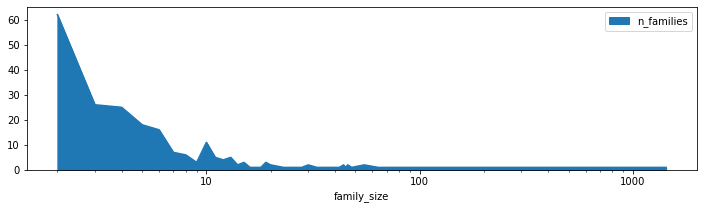

In [45]:
family_size = select_family_nlanguages.c.n_languages.label('family_size')

select_family_sizes = select([family_size, count().label('n_families')])\
                      .group_by(family_size)\
                      .order_by('family_size')

_ = read_sql(select_family_sizes, index_col=['family_size'])

_.plot.area(figsize=(12, 3), logx=True).xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
_.index.to_series().describe().to_frame().loc[['min', 'max']]

In [46]:
levels = sa.union_all(*[select([sa.literal(l).label('level')]) for l in LEVEL])\
         .cte(name='levels')

select_nchildren = select([Parent.id.label('parent_id'),
                           Parent.level.label('parent_level'),
                           levels.c.level.label('child_level'),
                           count(Child.id).label('n_children')])\
                   .select_from(sa.join(Parent, levels, sa.true())
                        .outerjoin(Child, sa.and_(Child.parent_id == Parent.id,
                                                  Child.level == levels.c.level)))\
                   .group_by(Parent.id, Parent.level, levels.c.level)

read_sql(select_nchildren)\
    .pivot_table(index='parent_level', columns='child_level', values='n_children',
                 aggfunc=['sum', 'max', 'mean'], fill_value=0)

WITH levels AS 
(SELECT ? AS level UNION ALL SELECT ? AS level UNION ALL SELECT ? AS level)
 SELECT parent.id AS parent_id, parent.level AS parent_level, levels.level AS child_level, count(child.id) AS n_children 
FROM languoid AS parent JOIN levels ON 1 LEFT OUTER JOIN languoid AS child ON child.parent_id = parent.id AND child.level = levels.level GROUP BY parent.id, parent.level, levels.level
('family', 'language', 'dialect')


sum                     max                      mean  \
child_level  dialect family language dialect family language   dialect   
parent_level                                                             
dialect         1781      0        0      22      0        0  0.145542   
family             0   4234     8328       0     45      393  0.000000   
language       10456      0        0      32      0        0  1.227951   

                                 
child_level     family language  
parent_level                     
dialect       0.000000  0.00000  
family        0.945934  1.86059  
language      0.000000  0.00000

In [47]:
select_ndescendants = select([Parent.id.label('parent_id'),
                              Parent.level.label('parent_level'),
                              count(Child.id).label('n_descendants')])\
                      .select_from(sa.join(Child, tree, tree.c.child_id == Child.id)
                          .join(Parent, tree.c.parent_id == Parent.id))\
                      .group_by(Parent.id, Parent.level)\
                      .alias()

n_descendants = select_ndescendants.c.n_descendants
d_min = sa.func.min(n_descendants).label('min')
d_max = sa.func.max(n_descendants).label('max')
d_mean = (sa.func.sum(n_descendants).cast(sa.Float) / count(n_descendants)).label('mean')

select_level_mean_descendants = select([select_ndescendants.c.parent_level,
                                        d_min, d_max, d_mean])\
                                .group_by(select_nchildren.c.parent_level)\
                                .order_by(select_nchildren.c.parent_level)

select_total_mean_descendants = select([sa.literal('total').label('parent_level'),
                                        d_min, d_max, d_mean])

select_mean_descendants = [select_level_mean_descendants, select_total_mean_descendants]

_ = pd.concat([read_sql(q, index_col=['parent_level']) for q in select_mean_descendants])
_.columns = pd.MultiIndex.from_product([['n_descendants'], _.columns])
_

WITH RECURSIVE tree(child_id, parent_id) AS 
(SELECT child.id AS child_id, parent.id AS parent_id 
FROM languoid AS child JOIN languoid AS parent ON child.parent_id = parent.id UNION ALL SELECT tree.child_id AS child_id, parent.parent_id AS parent_id 
FROM tree JOIN languoid AS parent ON parent.id = tree.parent_id AND parent.parent_id IS NOT NULL)
 SELECT anon_1.parent_level, min(anon_1.n_descendants) AS min, max(anon_1.n_descendants) AS max, CAST(sum(anon_1.n_descendants) AS FLOAT) / count(anon_1.n_descendants) AS mean 
FROM (SELECT parent.id AS parent_id, parent.level AS parent_level, count(child.id) AS n_descendants 
FROM languoid AS child JOIN tree ON tree.child_id = child.id JOIN languoid AS parent ON tree.parent_id = parent.id GROUP BY parent.id, parent.level) AS anon_1 GROUP BY parent_level ORDER BY parent_level
()
WITH RECURSIVE tree(child_id, parent_id) AS 
(SELECT child.id AS child_id, parent.id AS parent_id 
FROM languoid AS child JOIN languoid AS parent ON child.parent_id =

n_descendants                 
                       min   max       mean
parent_level                               
dialect                  1    57   4.694184
family                   1  4750  33.029267
language                 1   125   4.244537
total                    1  4750  20.600355

## macroarea

In [48]:
from treedb.models import Macroarea, languoid_macroarea

print_sql(Macroarea)
print_sql(languoid_macroarea)

SELECT sqlite_master.sql 
FROM sqlite_master 
WHERE sqlite_master.type = ? AND sqlite_master.name = ?
('table', 'macroarea')


CREATE TABLE macroarea (
	name VARCHAR(13) NOT NULL, 
	PRIMARY KEY (name), 
	CHECK (name IN ('Africa', 'Australia', 'Eurasia', 'North America', 'Papunesia', 'South America'))
) WITHOUT ROWID




SELECT count(*) AS n_rows 
FROM macroarea
()


6


SELECT sqlite_master.sql 
FROM sqlite_master 
WHERE sqlite_master.type = ? AND sqlite_master.name = ?
('table', 'languoid_macroarea')


CREATE TABLE languoid_macroarea (
	languoid_id VARCHAR(8) NOT NULL, 
	macroarea_name VARCHAR(13) NOT NULL, 
	PRIMARY KEY (languoid_id, macroarea_name), 
	FOREIGN KEY(languoid_id) REFERENCES languoid (id), 
	FOREIGN KEY(macroarea_name) REFERENCES macroarea (name)
) WITHOUT ROWID




SELECT count(*) AS n_rows 
FROM languoid_macroarea
()


20700


In [49]:
select_macroarea_nlanguages = select([Macroarea.name.label('macroarea'),
                                      count().label('n_languages')])\
                              .select_from(sa.outerjoin(Macroarea,
                                    sa.join(languoid_macroarea, Languoid)))\
                              .where(Languoid.level == LANGUAGE)\
                              .group_by(Macroarea.name)\
                              .order_by(sa.desc('n_languages'))

read_sql(select_macroarea_nlanguages, index_col='macroarea')

SELECT macroarea.name AS macroarea, count(*) AS n_languages 
FROM macroarea LEFT OUTER JOIN (languoid_macroarea JOIN languoid ON languoid.id = languoid_macroarea.languoid_id) ON macroarea.name = languoid_macroarea.macroarea_name 
WHERE languoid.level = ? GROUP BY macroarea.name ORDER BY n_languages DESC
('language',)


,n_languages
macroarea,
Africa,2347
Papunesia,2210
Eurasia,1970
North America,787
South America,712
Australia,386


In [50]:
macroareas = sa.func.group_concat(Macroarea.name, ', ').label('macroareas')

select_multiarea_languages = select([Languoid.id, Languoid.name, macroareas])\
                             .select_from(sa.join(Languoid, languoid_macroarea).join(Macroarea))\
                             .where(Languoid.level == LANGUAGE)\
                             .group_by(Languoid.id)\
                             .having(count() > 1)\
                             .order_by('id')
    
read_sql(select_multiarea_languages)

SELECT languoid.id, languoid.name, group_concat(macroarea.name, ?) AS macroareas 
FROM languoid JOIN languoid_macroarea ON languoid.id = languoid_macroarea.languoid_id JOIN macroarea ON macroarea.name = languoid_macroarea.macroarea_name 
WHERE languoid.level = ? GROUP BY languoid.id 
HAVING count(*) > ? ORDER BY languoid.id
(', ', 'language', 1)


,id,name,macroareas


## country

In [51]:
from treedb.models import Country, languoid_country

print_sql(Country)
print_sql(languoid_country)

SELECT sqlite_master.sql 
FROM sqlite_master 
WHERE sqlite_master.type = ? AND sqlite_master.name = ?
('table', 'country')


CREATE TABLE country (
	id VARCHAR(2) NOT NULL CHECK (length(id) = 2), 
	name TEXT NOT NULL CHECK (name != ''), 
	PRIMARY KEY (id), 
	UNIQUE (name)
) WITHOUT ROWID




SELECT count(*) AS n_rows 
FROM country
()


226


SELECT sqlite_master.sql 
FROM sqlite_master 
WHERE sqlite_master.type = ? AND sqlite_master.name = ?
('table', 'languoid_country')


CREATE TABLE languoid_country (
	languoid_id VARCHAR(8) NOT NULL, 
	country_id VARCHAR(2) NOT NULL, 
	PRIMARY KEY (languoid_id, country_id), 
	FOREIGN KEY(languoid_id) REFERENCES languoid (id), 
	FOREIGN KEY(country_id) REFERENCES country (id)
) WITHOUT ROWID




SELECT count(*) AS n_rows 
FROM languoid_country
()


10988


In [52]:
select_country_nlanguages = select([Country.name.label('country'),
                                    count().label('n_languages')])\
                            .select_from(sa.outerjoin(Country,
                                                      sa.join(languoid_country, Languoid)))\
                            .where(Languoid.level == LANGUAGE)\
                            .group_by(Country.id)\
                            .order_by(sa.desc('n_languages'))\
                            .limit(10)

read_sql(select_country_nlanguages, index_col='country')

SELECT country.name AS country, count(*) AS n_languages 
FROM country LEFT OUTER JOIN (languoid_country JOIN languoid ON languoid.id = languoid_country.languoid_id) ON country.id = languoid_country.country_id 
WHERE languoid.level = ? GROUP BY country.id ORDER BY n_languages DESC
 LIMIT ? OFFSET ?
('language', 10, 0)


,n_languages
country,
Papua New Guinea,897
Indonesia,744
Nigeria,572
India,498
China,398
Australia,393
Mexico,328
Brazil,324
United States,321


In [53]:
select_lc = select([Languoid.id, Languoid.name, Country.id.label('country')])\
            .select_from(sa.join(Languoid, languoid_country).join(Country))\
            .where(Languoid.level == LANGUAGE)\
            .order_by(Languoid.id, 'country')

countries = sa.func.group_concat(select_lc.c.country, ', ').label('countries')

select_multicountry_languages = select([select_lc.c.id,
                                        select_lc.c.name,
                                        count().label('n_countries'),
                                        countries])\
                                .group_by(select_lc.c.id, select_lc.c.name)\
                                .having(count() > 1)\
                                .order_by(sa.desc('n_countries'), select_lc.c.id)\
                                .limit(10)
    
read_sql(select_multicountry_languages, index_col='id')

SELECT id, name, count(*) AS n_countries, group_concat(country, ?) AS countries 
FROM (SELECT languoid.id AS id, languoid.name AS name, country.id AS country 
FROM languoid JOIN languoid_country ON languoid.id = languoid_country.languoid_id JOIN country ON country.id = languoid_country.country_id 
WHERE languoid.level = ? ORDER BY languoid.id, country) GROUP BY id, name 
HAVING count(*) > ? ORDER BY n_countries DESC, id
 LIMIT ? OFFSET ?
(', ', 'language', 1, 10, 0)


,name,n_countries,countries
id,,,
stan1288,Spanish,30,"AD, AR, BO, BR, BZ, CL, CO, CR, CU, DO, EC, ES..."
stan1293,English,26,"AU, BM, BR, BZ, CA, CK, CU, DO, FK, GB, GI, GP..."
stan1318,Standard Arabic,25,"AE, BH, DJ, DZ, EG, ER, IL, IQ, JO, KM, KW, LB..."
amer1248,American Sign Language,22,"BB, BF, BJ, BO, CA, CD, CF, CI, CN, GA, GH, JM..."
east2295,Eastern Yiddish,22,"AR, AU, BE, BY, CA, CR, EE, HU, IL, LT, LV, MD..."
russ1263,Russian,19,"BY, CN, EE, FI, GE, KG, KP, KZ, LT, LV, MD, MN..."
stan1295,German,16,"AT, BE, CH, CZ, DE, DK, FR, HU, IT, LI, LU, NL..."
port1283,Portuguese,15,"AD, AR, BO, BR, CO, ES, FR, GF, GY, PE, PT, PY..."
sint1235,Sinte Romani,13,"AT, CH, CZ, DE, FR, HR, IT, KZ, ME, NL, PL, RS..."


## endangerment

In [54]:
from treedb.models import Endangerment, EndangermentSource

print_sql(Endangerment)
print_sql(EndangermentSource)

SELECT sqlite_master.sql 
FROM sqlite_master 
WHERE sqlite_master.type = ? AND sqlite_master.name = ?
('table', 'endangerment')


CREATE TABLE endangerment (
	languoid_id VARCHAR(8) NOT NULL, 
	status VARCHAR(14) NOT NULL, 
	source_id INTEGER NOT NULL, 
	date DATETIME NOT NULL, 
	comment TEXT NOT NULL CHECK (comment != ''), 
	PRIMARY KEY (languoid_id), 
	FOREIGN KEY(languoid_id) REFERENCES languoid (id), 
	CHECK (status IN ('not endangered', 'threatened', 'shifting', 'moribund', 'nearly extinct', 'extinct')), 
	FOREIGN KEY(source_id) REFERENCES endangerment_source (id)
)


SELECT count(*) AS n_rows 
FROM endangerment
()


8165


SELECT sqlite_master.sql 
FROM sqlite_master 
WHERE sqlite_master.type = ? AND sqlite_master.name = ?
('table', 'endangerment_source')


CREATE TABLE endangerment_source (
	id INTEGER NOT NULL, 
	name TEXT NOT NULL CHECK (name != ''), 
	bibitem_id INTEGER, 
	pages TEXT CHECK (pages != ''), 
	PRIMARY KEY (id), 
	UNIQUE (bibitem_id, pages), 
	CHECK ((bibitem_id IS NULL) = (pages IS NULL)), 
	UNIQUE (name), 
	FOREIGN KEY(bibitem_id) REFERENCES bibitem (id)
)


SELECT count(*) AS n_rows 
FROM endangerment_source
()


11


SELECT endangerment_source.name AS source, count(*) AS n_endangerments 
FROM endangerment JOIN endangerment_source ON endangerment_source.id = endangerment.source_id GROUP BY endangerment_source.name ORDER BY n_endangerments DESC
()


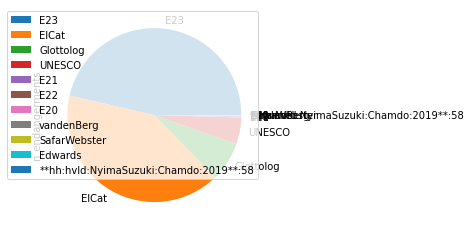

In [55]:
e_source = EndangermentSource.name.label('source')

select_source_nendangerments = select([e_source, count().label('n_endangerments')])\
                               .select_from(sa.join(Endangerment, EndangermentSource))\
                               .group_by(e_source)\
                               .order_by(sa.desc('n_endangerments'))

read_sql(select_source_nendangerments, index_col=['source']).plot.pie(y='n_endangerments');

## link

In [56]:
from treedb.models import Link

print_sql(Link)

SELECT sqlite_master.sql 
FROM sqlite_master 
WHERE sqlite_master.type = ? AND sqlite_master.name = ?
('table', 'link')


CREATE TABLE link (
	languoid_id VARCHAR(8) NOT NULL, 
	ord INTEGER NOT NULL CHECK (ord >= 1), 
	url TEXT NOT NULL CHECK (url != ''), 
	title TEXT CHECK (title != ''), 
	scheme TEXT, 
	PRIMARY KEY (languoid_id, ord), 
	UNIQUE (languoid_id, url), 
	CHECK (substr(url, 1, length(scheme) + 3) = scheme || '://'), 
	FOREIGN KEY(languoid_id) REFERENCES languoid (id), 
	CHECK (scheme IN ('http', 'https'))
)


SELECT count(*) AS n_rows 
FROM link
()


28949


SELECT link.scheme AS link_scheme, count(*) AS n_links 
FROM link GROUP BY link.scheme ORDER BY n_links DESC
()


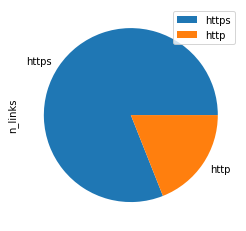

In [57]:
select_scheme_nlinks = select([Link.scheme.label('link_scheme'), count().label('n_links')])\
                       .group_by(Link.scheme)\
                       .order_by(sa.desc('n_links'))

read_sql(select_scheme_nlinks, index_col=['link_scheme']).plot.pie(y='n_links');

SELECT link.url 
FROM link
()


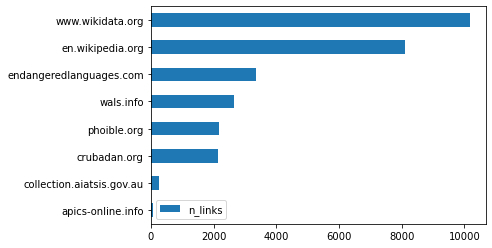

In [58]:
from urllib.parse import urlparse

hosts = collections.Counter(urlparse(u).hostname for u, in select([Link.url]).execute())

pd.DataFrame.from_dict(hosts, orient='index', columns=['n_links'])\
    .sort_values(by='n_links').plot.barh();

## denormalized

In [59]:
%time treedb.hash_csv(treedb.get_query())

WITH RECURSIVE tree(child_id, parent_id, steps, terminal) AS 
(SELECT child.id AS child_id, child.id AS parent_id, ? AS steps, child.parent_id IS NULL AS terminal 
FROM languoid AS child UNION ALL SELECT tree.child_id AS child_id, parent.parent_id AS parent_id, tree.steps + ? AS steps, grandparent.parent_id IS NULL AS terminal 
FROM tree JOIN languoid AS parent ON parent.id = tree.parent_id AND parent.parent_id IS NOT NULL LEFT OUTER JOIN languoid AS grandparent ON grandparent.id = parent.parent_id)
 SELECT languoid.id, languoid.name, languoid.level, languoid.parent_id, (SELECT group_concat(path_part, ?) AS path 
FROM (SELECT tree.parent_id AS path_part 
FROM tree 
WHERE tree.child_id = languoid.id ORDER BY tree.steps DESC)) AS path, (SELECT tree.parent_id 
FROM tree 
WHERE tree.child_id = languoid.id AND tree.steps > ? AND tree.terminal = 1) AS family_id, (SELECT tree.parent_id 
FROM tree 
WHERE tree.child_id = languoid.id AND languoid.level = ? AND (EXISTS (SELECT * 
FROM languoid AS

(0, 1, '/', 0, 'dialect', 'language', ', ', ', ', '[%s](%s)', ', ', ', ', '**%s:%s**:%s<trigger "%s">', '**%s:%s**:%s', '**%s:%s**<trigger "%s">', '**%s:%s**', 'glottolog', '', '%s [%s]', ', ', 'aiatsis', '', '%s [%s]', ', ', 'elcat', '', '%s [%s]', ', ', 'ethnologue', '', '%s [%s]', ', ', 'glottolog', '', '%s [%s]', ', ', 'hhbib_lgcode', '', '%s [%s]', ', ', 'lexvo', '', '%s [%s]', ', ', 'moseley & asher (1994)', '', '%s [%s]', ', ', 'multitree', '', '%s [%s]', ', ', 'ruhlen (1987)', '', '%s [%s]', ', ', 'wals', '', '%s [%s]', ', ', 'wals other', ', ', 'lgcode', ', ', 'inlg', ', ', '**%s:%s**:%s', '**%s:%s**', 'sub', ', ', '**%s:%s**:%s', '**%s:%s**', 'family', '**%s:%s**:%s', ', ', 'endangeredlanguages', 'languagelandscape', 'multitree', 'wals', 'sub', 'family')
[INFO@treedb.queries] hash rows with 'sha256', header: ['id', 'name', 'level', 'parent_id', 'path', 'family_id', 'dialect_language_id', 'hid', 'iso639_3', 'latitude', 'longitude', 'macroareas', 'countries', 'links', 'sources_

Wall time: 9.97 s


'90d180f3c2beff26763359945f68e8ac94faf4379d1e36807ee9d7b835821ae8'